In [ ]:
import pandas as pd
import numpy as np  

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [40]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

# 옵션: 경고 줄이기
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

In [19]:
df = pd.read_csv("../data/kospi_df.csv")

In [20]:
df.head()

,date,close,high,low,open,volume,ret_1d,ret_5d,ret_22d,ma_5,...,momentum_60,drawdown_60,max_drawdown_60,usdkrw,gold_price,vix,news_emotion,forward_return,rolling_5yr_mean,market_forward_excess_returns
0,2005-01-03,893.710022,897.590027,890.929993,896.000000,252600,-0.002467,0.015672,0.019286,885.862000,...,12.330017,-0.002467,-0.089368,1027.300049,428.700012,14.08,101.07,-0.007620,0.000074,-0.007694
1,2005-01-04,886.900024,895.400024,884.940002,890.559998,331600,-0.007620,0.011312,0.003167,887.846008,...,5.790039,-0.010068,-0.089368,1028.699951,428.500000,13.98,101.52,-0.001928,0.000072,-0.002000
2,2005-01-05,885.190002,885.200012,873.179993,874.919983,343100,-0.001928,0.007696,0.002991,889.198010,...,27.099976,-0.011976,-0.089368,1035.800049,426.600006,14.09,102.00,-0.015714,0.000059,-0.015773
3,2005-01-06,871.280029,886.309998,871.280029,878.229981,394700,-0.015714,-0.014690,0.000609,886.600012,...,15.100037,-0.027502,-0.089368,1048.400024,421.000000,13.58,101.45,-0.000505,0.000059,-0.000564
4,2005-01-07,870.840027,878.890015,866.719971,876.359985,294800,-0.000505,-0.027994,0.011346,881.584021,...,24.210022,-0.027994,-0.089368,1045.099976,418.899994,13.49,102.14,0.003835,0.000062,0.003773


In [21]:
train_ratio = 0.85   # 앞 85%는 train, 뒤 15%는 test
cutoff = int(len(df) * train_ratio)

df["is_train"] = 0
df.loc[:cutoff, "is_train"] = 1

train_df = df[df["is_train"] == 1].copy()
test_df  = df[df["is_train"] == 0].copy()

print("Train 기간:", train_df["date"].min(), "→", train_df["date"].max(), ", N =", len(train_df))
print("Test  기간:", test_df["date"].min(),  "→", test_df["date"].max(),  ", N =", len(test_df))

Train 기간: 2005-01-03 → 2021-12-21 , N = 4194
Test  기간: 2021-12-22 → 2024-12-27 , N = 739


시계열의 순서를 흐리지 않도록 유지하며 Train/Test를 나누었습니다

In [22]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'ret_1d', 'ret_5d',
       'ret_22d', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'vol_22d', 'rsi_14',
       'macd', 'macd_signal', 'macd_hist', 'atr_14', 'bb_middle', 'bb_upper',
       'bb_lower', 'momentum_10', 'momentum_20', 'momentum_60', 'drawdown_60',
       'max_drawdown_60', 'usdkrw', 'gold_price', 'vix', 'news_emotion',
       'forward_return', 'rolling_5yr_mean', 'market_forward_excess_returns',
       'is_train'],
      dtype='object')

In [23]:
# 3-1. 사용하지 않을 컬럼들 (타깃, 날짜, 메타 등)
drop_cols = [
    "date",
    "is_train",
    "forward_return",
    "forward_returns",
    "risk_free_rate",
    "market_forward_excess_returns",
    "rolling_5yr_mean", # target columns
        "year", "month", "day", "dow",
    "week_of_month", "dayofweek", "month_part", #calendar cols
    "close", "open", "high", "low" #leak_like_cols
]

feature_cols = [c for c in df.columns if c not in drop_cols]

print("Feature 개수:", len(feature_cols))
print("예시:", feature_cols[:10])

X_train = train_df[feature_cols].copy()
y_train = train_df["market_forward_excess_returns"].copy()

X_test  = test_df[feature_cols].copy()
y_test  = test_df["market_forward_excess_returns"].copy()

Feature 개수: 26
예시: ['volume', 'ret_1d', 'ret_5d', 'ret_22d', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'vol_22d', 'rsi_14']


In [24]:
X_train = X_train.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
X_test  = X_test.fillna(method="ffill").fillna(method="bfill").fillna(0.0)

In [25]:
# metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def corr(y_true, y_pred):
    if len(y_true) < 3:
        return np.nan
    return np.corrcoef(y_true, y_pred)[0, 1]

## Raw ElasticNet

In [26]:
# baseline

tscv = TimeSeriesSplit(n_splits=5)

raw_results = []
raw_oof_pred = np.zeros(len(X_train))

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    # 스케일링 (fold별로 fit)
    scaler = StandardScaler()
    X_tr_sc = scaler.fit_transform(X_tr)
    X_val_sc = scaler.transform(X_val)
    
    # 간단한 ElasticNet (하이퍼는 필요시 grid-search)
    model = ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=5000)
    model.fit(X_tr_sc, y_tr)
    
    val_pred = model.predict(X_val_sc)
    raw_oof_pred[val_idx] = val_pred
    
    fold_rmse = rmse(y_val, val_pred)
    fold_corr = corr(y_val, val_pred)
    raw_results.append({"fold": fold, "rmse": fold_rmse, "corr": fold_corr})
    print(f"[Raw ENET] Fold {fold}: RMSE={fold_rmse:.6f}, Corr={fold_corr:.4f}")

raw_results_df = pd.DataFrame(raw_results)
print("\n=== Raw ElasticNet TS-CV Summary ===")
print(raw_results_df.agg({"rmse":["mean","std"], "corr":["mean","std"]}))


[Raw ENET] Fold 1: RMSE=0.013539, Corr=-0.0033
[Raw ENET] Fold 2: RMSE=0.010562, Corr=0.1365
[Raw ENET] Fold 3: RMSE=0.007544, Corr=0.1173
[Raw ENET] Fold 4: RMSE=0.007271, Corr=0.0667
[Raw ENET] Fold 5: RMSE=0.010569, Corr=0.0535

=== Raw ElasticNet TS-CV Summary ===
          rmse      corr
mean  0.009897  0.074139
std   0.002578  0.055317


## PCA 이후 ElasticNet

In [27]:
N_COMP = 5  # Scree, Kaiser 결과 기반으로 결정 (ex: 5)

pca_results = []
pca_oof_pred = np.zeros(len(X_train))

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    # 1) 스케일링
    scaler = StandardScaler()
    X_tr_sc = scaler.fit_transform(X_tr)
    X_val_sc = scaler.transform(X_val)
    
    # 2) PCA (fold별로 fit)
    pca = PCA(n_components=N_COMP, random_state=0)
    X_tr_pca = pca.fit_transform(X_tr_sc)
    X_val_pca = pca.transform(X_val_sc)
    
    # 3) ElasticNet
    model = ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=5000)
    model.fit(X_tr_pca, y_tr)
    
    val_pred = model.predict(X_val_pca)
    pca_oof_pred[val_idx] = val_pred
    
    fold_rmse = rmse(y_val, val_pred)
    fold_corr = corr(y_val, val_pred)
    pca_results.append({"fold": fold, "rmse": fold_rmse, "corr": fold_corr})
    print(f"[PCA ENET] Fold {fold}: RMSE={fold_rmse:.6f}, Corr={fold_corr:.4f}")

pca_results_df = pd.DataFrame(pca_results)
print("\n=== PCA + ElasticNet TS-CV Summary ===")
print(pca_results_df.agg({"rmse":["mean","std"], "corr":["mean","std"]}))

[PCA ENET] Fold 1: RMSE=0.013477, Corr=0.0181
[PCA ENET] Fold 2: RMSE=0.010581, Corr=0.1428
[PCA ENET] Fold 3: RMSE=0.007540, Corr=0.0987
[PCA ENET] Fold 4: RMSE=0.007284, Corr=0.0556
[PCA ENET] Fold 5: RMSE=0.010576, Corr=0.0305

=== PCA + ElasticNet TS-CV Summary ===
          rmse      corr
mean  0.009892  0.069152
std   0.002556  0.051412


In [28]:
compare_cv = pd.DataFrame({
    "model": ["ElasticNet_raw", "ElasticNet_PCA"],
    "rmse_mean": [raw_results_df["rmse"].mean(), pca_results_df["rmse"].mean()],
    "rmse_std":  [raw_results_df["rmse"].std(),  pca_results_df["rmse"].std()],
    "corr_mean": [raw_results_df["corr"].mean(), pca_results_df["corr"].mean()],
    "corr_std":  [raw_results_df["corr"].std(),  pca_results_df["corr"].std()],
})
compare_cv

,model,rmse_mean,rmse_std,corr_mean,corr_std
0,ElasticNet_raw,0.009897,0.002578,0.074139,0.055317
1,ElasticNet_PCA,0.009892,0.002556,0.069152,0.051412


In [29]:
import lightgbm as lgb

tscv = TimeSeriesSplit(n_splits=5)

lgb_results = []
lgb_oof = np.zeros(len(X_train))

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    
    X_tr = X_train.iloc[tr_idx]
    X_val = X_train.iloc[val_idx]
    y_tr = y_train.iloc[tr_idx]
    y_val = y_train.iloc[val_idx]
    
    train_set = lgb.Dataset(X_tr, y_tr)
    val_set = lgb.Dataset(X_val, y_val)
    
    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.01,
        "num_leaves": 31,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.7,
        "bagging_freq": 5,
        "seed": 42
    }
    
    model = lgb.train(
        params,
        train_set,
        valid_sets=[val_set],
        num_boost_round=3000,
    )
    
    pred = model.predict(X_val)
    lgb_oof[val_idx] = pred
    
    fold_rmse = rmse(y_val, pred)
    fold_corr = corr(y_val, pred)
    lgb_results.append({"fold": fold, "rmse": fold_rmse, "corr": fold_corr})
    print(f"[LGBM] Fold {fold}: RMSE={fold_rmse:.6f} Corr={fold_corr:.4f}")

lgb_results_df = pd.DataFrame(lgb_results)
lgb_results_df.agg({"rmse": ["mean","std"], "corr": ["mean","std"]})


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5835
[LightGBM] [Info] Number of data points in the train set: 699, number of used features: 26
[LightGBM] [Info] Start training from score 0.000766
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,rmse,corr
mean,0.012374,0.078146
std,0.004745,0.078692


In [30]:
import xgboost as xgb

xgb_results = []
xgb_oof = np.zeros(len(X_train))

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    
    X_tr = X_train.iloc[tr_idx]
    X_val = X_train.iloc[val_idx]
    y_tr = y_train.iloc[tr_idx]
    y_val = y_train.iloc[val_idx]

    model = xgb.XGBRegressor(
        n_estimators=3000,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.7,
        colsample_bytree=0.9,
        random_state=42,
        tree_method="hist"
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
    )
    
    pred = model.predict(X_val)
    xgb_oof[val_idx] = pred
    
    fold_rmse = rmse(y_val, pred)
    fold_corr = corr(y_val, pred)
    xgb_results.append({"fold": fold, "rmse": fold_rmse, "corr": fold_corr})
    print(f"[XGB] Fold {fold}: RMSE={fold_rmse:.6f} Corr={fold_corr:.4f}")

xgb_results_df = pd.DataFrame(xgb_results)
xgb_results_df.agg({"rmse": ["mean","std"], "corr": ["mean","std"]})


[0]	validation_0-rmse:0.01346
[1]	validation_0-rmse:0.01345
[2]	validation_0-rmse:0.01345
[3]	validation_0-rmse:0.01345
[4]	validation_0-rmse:0.01344
[5]	validation_0-rmse:0.01344
[6]	validation_0-rmse:0.01344
[7]	validation_0-rmse:0.01344
[8]	validation_0-rmse:0.01343
[9]	validation_0-rmse:0.01343
[10]	validation_0-rmse:0.01342
[11]	validation_0-rmse:0.01342
[12]	validation_0-rmse:0.01343
[13]	validation_0-rmse:0.01342
[14]	validation_0-rmse:0.01343
[15]	validation_0-rmse:0.01342
[16]	validation_0-rmse:0.01341
[17]	validation_0-rmse:0.01341
[18]	validation_0-rmse:0.01341
[19]	validation_0-rmse:0.01342
[20]	validation_0-rmse:0.01341
[21]	validation_0-rmse:0.01342
[22]	validation_0-rmse:0.01342
[23]	validation_0-rmse:0.01343
[24]	validation_0-rmse:0.01343
[25]	validation_0-rmse:0.01343
[26]	validation_0-rmse:0.01344
[27]	validation_0-rmse:0.01344
[28]	validation_0-rmse:0.01344
[29]	validation_0-rmse:0.01344
[30]	validation_0-rmse:0.01345
[31]	validation_0-rmse:0.01346
[32]	validation_0-

,rmse,corr
mean,0.011965,0.072863
std,0.003534,0.048497


## Model Blend

In [31]:
oof_df = pd.DataFrame({
    "enet_raw": raw_oof_pred,
    "enet_pca": pca_oof_pred,
    "lgb": lgb_oof,
    "xgb": xgb_oof,
    "y": y_train.values,
})

# 최소 하나라도 예측이 존재하는 구간만 사용
mask_valid = (oof_df[["enet_raw","enet_pca","lgb","xgb"]].abs().sum(axis=1) != 0)
oof_valid = oof_df[mask_valid].reset_index(drop=True)

print(oof_valid.head())  # 이제는 0만 있는 줄이 없어야 정상

   enet_raw  enet_pca       lgb       xgb         y
0 -0.000478  0.000727  0.001380  0.000375  0.005081
1 -0.000272  0.000710  0.003074 -0.001508 -0.001848
2 -0.000668  0.000720 -0.007071 -0.007503 -0.022225
3 -0.000292  0.000767 -0.001191 -0.004788 -0.002772
4 -0.000315  0.000768 -0.003836 -0.003677  0.018079


In [32]:
steps = np.linspace(0, 1, 11)
candidates = []

for w_enet in steps:
    for w_lgb in steps:
        w_xgb = 1.0 - w_enet - w_lgb
        if w_xgb < 0 or w_xgb > 1:
            continue
        
        pred_blend = (
            w_enet * oof_valid["enet_pca"]
            + w_lgb * oof_valid["lgb"]
            + w_xgb * oof_valid["xgb"]
        )
        
        r = rmse(oof_valid["y"], pred_blend)
        c = corr(oof_valid["y"], pred_blend)
        candidates.append({
            "w_enet_pca": w_enet,
            "w_lgb": w_lgb,
            "w_xgb": w_xgb,
            "rmse": r,
            "corr": c,
        })

blend_df = pd.DataFrame(candidates)
blend_df.sort_values("rmse").head(10)


,w_enet_pca,w_lgb,w_xgb,rmse,corr
59,1.0,0.0,0.0,0.010152,0.009617
58,0.9,0.0,0.1,0.010155,0.042089
56,0.8,0.0,0.2,0.010211,0.048763
57,0.8,0.1,0.1,0.010220,0.044111
53,0.7,0.0,0.3,0.010321,0.050327
54,0.7,0.1,0.2,0.010330,0.047100
55,0.7,0.2,0.1,0.010356,0.042035
49,0.6,0.0,0.4,0.010482,0.050810
50,0.6,0.1,0.3,0.010490,0.048348
51,0.6,0.2,0.2,0.010516,0.044748


In [33]:
# 예시: PCA+ElasticNet 최종 학습 & 예측
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet

# X_train, y_train, X_test, y_test 가 있다고 가정
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

pca = PCA(n_components=5, random_state=0)  # 너가 Kaiser rule로 뽑은 개수
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca  = pca.transform(X_test_sc)

enet = ElasticNet(alpha=1e-3, l1_ratio=0.5, max_iter=5000, random_state=0)
enet.fit(X_train_pca, y_train)

enet_test_pred = enet.predict(X_test_pca)  # ← 이게 신호

In [34]:
blend_test_pred = (
    1.0 * enet_test_pred   
)

signal = blend_test_pred  

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_k_grid(
    returns: pd.Series,
    signal: pd.Series,
    k_list=None,
    max_vol_ratio: float = 1.2,
    plot: bool = True,
    name: str = "KOSPI Strategy"
):
    """
    returns : 실제 일간 수익률 (KOSPI 수익률, pd.Series)
    signal  : 모델 예측값 (enet_test_pred 또는 blend_test_pred)
    k_list  : 탐색할 k 값 리스트 (없으면 0~1 사이 0.1 step)
    max_vol_ratio : 전략 연율화 변동성 / 벤치마크 변동성 최대 비율 (기본 1.2)
    plot    : True면 best k에 대한 그래프를 그림
    """
    assert len(returns) == len(signal)
    returns = returns.reset_index(drop=True)
    signal  = signal.reset_index(drop=True)

    if k_list is None:
        k_list = np.linspace(0.0, 1.0, 11)  # 0.0, 0.1, ..., 1.0

    # 벤치마크: buy & hold (그냥 KOSPI 수익률 누적)
    mkt_ret = returns.copy()
    ann = np.sqrt(252)
    mkt_vol_ann = mkt_ret.std() * ann
    mkt_mean_ann = mkt_ret.mean() * 252
    mkt_sharpe = mkt_mean_ann / (mkt_vol_ann + 1e-12)

    # 신호 표준화 (전 구간 기준 z-score)
    sig_mean = signal.mean()
    sig_std  = signal.std()
    z = (signal - sig_mean) / (sig_std + 1e-12)

    results = []

    for k in k_list:
        # 1) 0~2 비중으로 매핑
        raw_pos = 1.0 + k * z
        raw_pos = raw_pos.clip(0.0, 2.0)

        strat_ret_raw = raw_pos * returns

        strat_vol_raw_ann = strat_ret_raw.std() * ann
        vol_ratio_raw = strat_vol_raw_ann / (mkt_vol_ann + 1e-12)

        # 2) 변동성 제약 스케일링
        if vol_ratio_raw <= max_vol_ratio:
            scale = 1.0
        else:
            scale = max_vol_ratio / (vol_ratio_raw + 1e-12)

        pos = (raw_pos * scale).clip(0.0, 2.0)
        strat_ret = pos * returns

        strat_vol_ann = strat_ret.std() * ann
        strat_mean_ann = strat_ret.mean() * 252
        sharpe = strat_mean_ann / (strat_vol_ann + 1e-12)

        # 누적수익/드로우다운
        strat_cum = (1 + strat_ret).cumprod()
        strat_cum_max = strat_cum.cummax()
        strat_dd = strat_cum / strat_cum_max - 1.0
        max_dd = strat_dd.min() * 100  # %

        results.append({
            "k": k,
            "scale": scale,
            "sharpe": sharpe,
            "vol_ratio": strat_vol_ann / (mkt_vol_ann + 1e-12),
            "max_dd": max_dd,
            "ann_ret": strat_mean_ann * 100,
            "ann_vol": strat_vol_ann * 100,
        })

    results_df = pd.DataFrame(results).sort_values("sharpe", ascending=False)
    best = results_df.iloc[0]

    print("=== Benchmark (KOSPI Buy&Hold) ===")
    print(f"Annualized Return : {mkt_mean_ann*100:.3f}%")
    print(f"Annualized Vol    : {mkt_vol_ann*100:.3f}%")
    print(f"Sharpe            : {mkt_sharpe:.3f}")
    print()
    print(f"=== {name} (Best k) ===")
    print(f"Best k            : {best['k']:.3f}")
    print(f"Position scale    : {best['scale']:.3f}")
    print(f"Annualized Return : {best['ann_ret']:.3f}%")
    print(f"Annualized Vol    : {best['ann_vol']:.3f}%")
    print(f"Vol Ratio         : {best['vol_ratio']:.3f}x")
    print(f"Sharpe            : {best['sharpe']:.3f}")
    print(f"Max Drawdown      : {best['max_dd']:.2f}%")

    # 베스트 k에 대한 시계열 다시 계산 (그래프용)
    k_star = best["k"]
    scale_star = best["scale"]

    raw_pos_star = (1.0 + k_star * z).clip(0.0, 2.0)
    pos_star = (raw_pos_star * scale_star).clip(0.0, 2.0)
    strat_ret_star = pos_star * returns

    strat_cum_star = (1 + strat_ret_star).cumprod()
    mkt_cum = (1 + mkt_ret).cumprod()

    strat_cum_max_star = strat_cum_star.cummax()
    strat_dd_star = strat_cum_star / strat_cum_max_star - 1.0

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

        axes[0].plot(mkt_cum.values, label="KOSPI Buy&Hold", alpha=0.8)
        axes[0].plot(strat_cum_star.values, label=f"{name} (k={k_star:.2f})", alpha=0.8)
        axes[0].set_title("Cumulative Return")
        axes[0].legend()

        axes[1].plot(strat_dd_star.values * 100)
        axes[1].set_title("Strategy Drawdown (%)")
        axes[1].set_xlabel("Time")

        plt.tight_layout()
        plt.show()

    return results_df, k_star, scale_star, strat_ret_star


In [ ]:
def backtest_k_grid(
    returns: pd.Series,
    signal: pd.Series,
    k_list=None,
    max_vol_ratio: float = 1.2,
    plot: bool = True,
    name: str = "KOSPI Strategy"
):
    """
    returns : 실제 일간 수익률 (KOSPI 수익률, pd.Series)
    signal  : 모델 예측값 (enet_test_pred 또는 blend_test_pred)
    k_list  : 탐색할 k 값 리스트 (없으면 0~1 사이 0.1 step)
    max_vol_ratio : 전략 연율화 변동성 / 벤치마크 변동성 최대 비율 (기본 1.2)
    plot    : True면 best k에 대한 그래프를 그림
    """
    assert len(returns) == len(signal)
    returns = returns.reset_index(drop=True)
    signal  = signal.reset_index(drop=True)

    if k_list is None:
        k_list = np.linspace(0.0, 1.0, 11)  # 0.0, 0.1, ..., 1.0

    # 벤치마크: buy & hold (그냥 KOSPI 수익률 누적)
    mkt_ret = returns.copy()
    ann = np.sqrt(252)
    mkt_vol_ann = mkt_ret.std() * ann
    mkt_mean_ann = mkt_ret.mean() * 252
    mkt_sharpe = mkt_mean_ann / (mkt_vol_ann + 1e-12)

    # 신호 표준화 (전 구간 기준 z-score)
    sig_mean = signal.mean()
    sig_std  = signal.std()
    z = (signal - sig_mean) / (sig_std + 1e-12)

    results = []

    for k in k_list:
        # 1) 0~2 비중으로 매핑
        raw_pos = 1.0 + k * z
        raw_pos = raw_pos.clip(0.0, 2.0)

        strat_ret_raw = raw_pos * returns

        strat_vol_raw_ann = strat_ret_raw.std() * ann
        vol_ratio_raw = strat_vol_raw_ann / (mkt_vol_ann + 1e-12)

        # 2) 변동성 제약 스케일링
        if vol_ratio_raw <= max_vol_ratio:
            scale = 1.0
        else:
            scale = max_vol_ratio / (vol_ratio_raw + 1e-12)

        pos = (raw_pos * scale).clip(0.0, 2.0)
        strat_ret = pos * returns

        strat_vol_ann = strat_ret.std() * ann
        strat_mean_ann = strat_ret.mean() * 252
        sharpe = strat_mean_ann / (strat_vol_ann + 1e-12)

        # 누적수익/드로우다운
        strat_cum = (1 + strat_ret).cumprod()
        strat_cum_max = strat_cum.cummax()
        strat_dd = strat_cum / strat_cum_max - 1.0
        max_dd = strat_dd.min() * 100  # %

        results.append({
            "k": k,
            "scale": scale,
            "sharpe": sharpe,
            "vol_ratio": strat_vol_ann / (mkt_vol_ann + 1e-12),
            "max_dd": max_dd,
            "ann_ret": strat_mean_ann * 100,
            "ann_vol": strat_vol_ann * 100,
        })

    results_df = pd.DataFrame(results).sort_values("sharpe", ascending=False)
    best = results_df.iloc[0]

    print("=== Benchmark (KOSPI Buy&Hold) ===")
    print(f"Annualized Return : {mkt_mean_ann*100:.3f}%")
    print(f"Annualized Vol    : {mkt_vol_ann*100:.3f}%")
    print(f"Sharpe            : {mkt_sharpe:.3f}")
    print()
    print(f"=== {name} (Best k) ===")
    print(f"Best k            : {best['k']:.3f}")
    print(f"Position scale    : {best['scale']:.3f}")
    print(f"Annualized Return : {best['ann_ret']:.3f}%")
    print(f"Annualized Vol    : {best['ann_vol']:.3f}%")
    print(f"Vol Ratio         : {best['vol_ratio']:.3f}x")
    print(f"Sharpe            : {best['sharpe']:.3f}")
    print(f"Max Drawdown      : {best['max_dd']:.2f}%")

    # 베스트 k에 대한 시계열 다시 계산 (그래프용)
    k_star = best["k"]
    scale_star = best["scale"]

    raw_pos_star = (1.0 + k_star * z).clip(0.0, 2.0)
    pos_star = (raw_pos_star * scale_star).clip(0.0, 2.0)
    strat_ret_star = pos_star * returns

    strat_cum_star = (1 + strat_ret_star).cumprod()
    mkt_cum = (1 + mkt_ret).cumprod()

    strat_cum_max_star = strat_cum_star.cummax()
    strat_dd_star = strat_cum_star / strat_cum_max_star - 1.0

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

        axes[0].plot(mkt_cum.values, label="KOSPI Buy&Hold", alpha=0.8)
        axes[0].plot(strat_cum_star.values, label=f"{name} (k={k_star:.2f})", alpha=0.8)
        axes[0].set_title("Cumulative Return")
        axes[0].legend()

        axes[1].plot(strat_dd_star.values * 100)
        axes[1].set_title("Strategy Drawdown (%)")
        axes[1].set_xlabel("Time")

        plt.tight_layout()
        plt.show()

    return results_df, k_star, scale_star, strat_ret_star


=== Benchmark (KOSPI Buy&Hold) ===
Annualized Return : -6.990%
Annualized Vol    : 16.155%
Sharpe            : -0.433

=== KOSPI PCA+ElasticNet (Best k) ===
Best k            : 1.000
Position scale    : 0.894
Annualized Return : 8.822%
Annualized Vol    : 19.386%
Vol Ratio         : 1.200x
Sharpe            : 0.455
Max Drawdown      : -25.11%


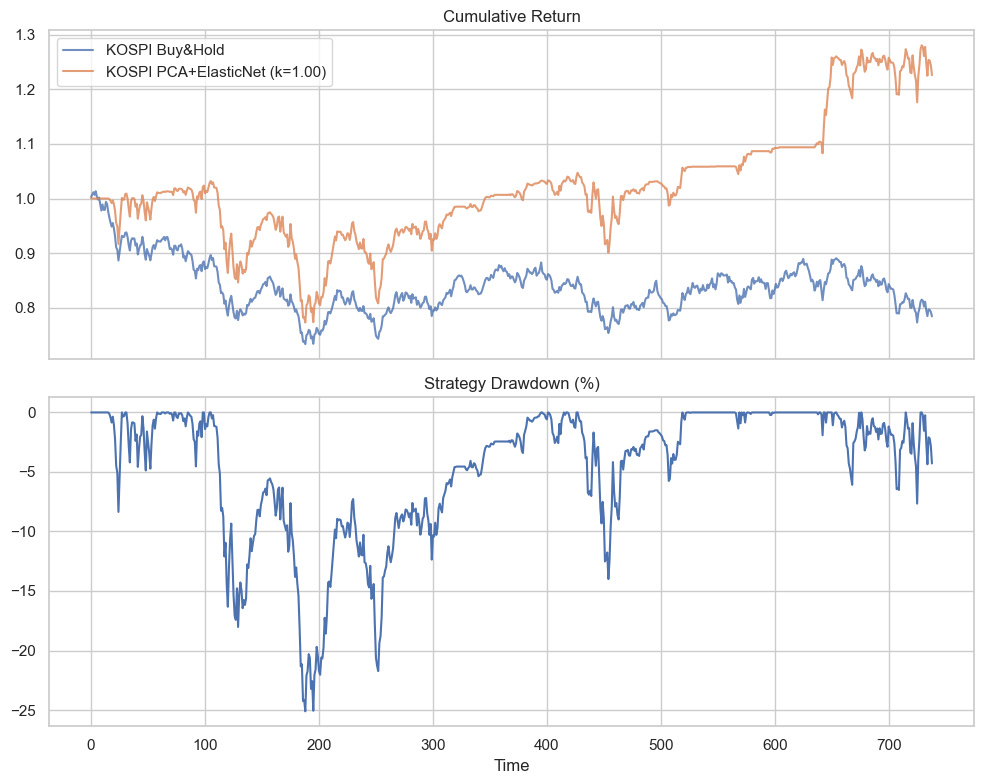

In [ ]:
# returns: KOSPI test 구간 수익률 (pd.Series)
# signal : enet_test_pred 또는 blend_test_pred (길이 동일)

returns = pd.Series(y_test.values, index=y_test.index)   # 이름 맞춰줘도 되고
signal  = pd.Series(enet_test_pred, index=y_test.index)  # 또는 blend_test_pred

results_df, best_k, best_scale, strat_ret_star = backtest_k_grid(
    returns=returns,
    signal=signal,
    max_vol_ratio=1.2,
    name="KOSPI PCA+ElasticNet"
)

## Leakage-free codes

In [37]:
target_col = "market_forward_excess_returns"

# 3-1. 사용하지 않을 컬럼들 (타깃, 날짜, 메타 등)
drop_cols = [
    "date",
    "is_train",
    "forward_return",
    "forward_returns",
    "risk_free_rate",
    "market_forward_excess_returns",
    "rolling_5yr_mean", # target columns
        "year", "month", "day", "dow",
    "week_of_month", "dayofweek", "month_part", #calendar cols
    "close", "open", "high", "low" #leak_like_cols
]

feature_cols = [c for c in df.columns if c not in drop_cols]

print("Feature 개수:", len(feature_cols))
print("예시:", feature_cols[:10])

Feature 개수: 26
예시: ['volume', 'ret_1d', 'ret_5d', 'ret_22d', 'ma_5', 'ma_20', 'ma_60', 'ma_120', 'vol_22d', 'rsi_14']


In [38]:
split_ratio = 0.8   # 앞 80% train, 뒤 20% test 예시
split_idx = int(len(df) * split_ratio)

train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_test  = test_df[feature_cols].values
y_test  = test_df[target_col].values

In [39]:
# TS-CV 설정
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# OOF 예측을 저장할 배열
oof_pred_enet_pca = np.zeros_like(y_train, dtype=float)

# PCA / ElasticNet 하이퍼파라미터 (앞에서 대략 골라둔 값 사용)
N_COMP = 5          # Kaiser rule 결과, PC 개수
ALPHA  = 1e-3
L1R    = 0.5

fold_metrics = []

for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    # 1) scaler & PCA는 "해당 fold의 train"에 대해서만 fit → leakage 방지
    scaler = StandardScaler()
    X_tr_sc = scaler.fit_transform(X_tr)
    X_val_sc = scaler.transform(X_val)

    pca = PCA(n_components=N_COMP, random_state=0)
    X_tr_pca = pca.fit_transform(X_tr_sc)
    X_val_pca = pca.transform(X_val_sc)

    # 2) ElasticNet 학습
    enet = ElasticNet(alpha=ALPHA, l1_ratio=L1R,
                      max_iter=5000, random_state=0)
    enet.fit(X_tr_pca, y_tr)

    # 3) validation 예측 → OOF에 적재
    val_pred = enet.predict(X_val_pca)
    oof_pred_enet_pca[val_idx] = val_pred

    # 간단한 fold별 RMSE / corr
    rmse = np.sqrt(((y_val - val_pred) ** 2).mean())
    corr = np.corrcoef(y_val, val_pred)[0, 1]
    fold_metrics.append((fold, rmse, corr))
    print(f"[Fold {fold}] RMSE={rmse:.6f}, Corr={corr:.4f}")

rmse_oof = np.sqrt(((y_train - oof_pred_enet_pca) ** 2).mean())
corr_oof = np.corrcoef(y_train, oof_pred_enet_pca)[0, 1]
print("\n=== ElasticNet+PCA OOF Performance (Train only) ===")
print(f"RMSE (OOF): {rmse_oof:.6f}")
print(f"Corr (OOF): {corr_oof:.4f}")


[Fold 1] RMSE=0.013824, Corr=0.1007
[Fold 2] RMSE=0.011059, Corr=0.1028
[Fold 3] RMSE=0.006949, Corr=0.0838
[Fold 4] RMSE=0.007530, Corr=0.0330
[Fold 5] RMSE=0.010111, Corr=0.0075

=== ElasticNet+PCA OOF Performance (Train only) ===
RMSE (OOF): 0.010299
Corr (OOF): 0.0184


In [ ]:
# train 구간 실제 수익률 / 예측 신호
train_returns = pd.Series(y_train, index=train_df.index, name="ret")
train_signal  = pd.Series(oof_pred_enet_pca, index=train_df.index, name="signal")

def evaluate_strategy_from_signal(returns, signal, k, max_vol_ratio=1.2):
    """
    returns: 실제 수익률 (Series)
    signal : 예측값 (Series)
    """
    z = (signal - signal.mean()) / (signal.std() + 1e-12)
    raw_pos = (1.0 + k * z).clip(0.0, 2.0)   # 0~2 비중

    strat_ret_raw = raw_pos * returns
    mkt_ret = returns

    ann = np.sqrt(252)
    strat_vol_raw = strat_ret_raw.std() * ann
    mkt_vol = mkt_ret.std() * ann

    vol_ratio_raw = strat_vol_raw / (mkt_vol + 1e-12)

    # 변동성 제약 적용
    if vol_ratio_raw <= max_vol_ratio:
        scale = 1.0
    else:
        scale = max_vol_ratio / (vol_ratio_raw + 1e-12)

    pos = (raw_pos * scale).clip(0.0, 2.0)
    strat_ret = pos * returns

    strat_vol = strat_ret.std() * ann
    strat_mean = strat_ret.mean() * 252
    sharpe = strat_mean / (strat_vol + 1e-12)

    # max DD
    strat_cum = (1 + strat_ret).cumprod()
    cum_max = strat_cum.cummax()
    dd = strat_cum / cum_max - 1.0
    max_dd = dd.min() * 100

    return {
        "k": k,
        "scale": scale,
        "sharpe": sharpe,
        "vol_ratio": strat_vol / (mkt_vol + 1e-12),
        "ann_ret": strat_mean * 100,
        "ann_vol": strat_vol * 100,
        "max_dd": max_dd,
    }

# k 그리드서치 (train 데이터로만)
k_list = np.linspace(0.0, 1.0, 11)  # 0.0 ~ 1.0, 0.1 step
res_list = []

for k in k_list:
    res = evaluate_strategy_from_signal(train_returns, train_signal, k)
    res_list.append(res)

k_results = pd.DataFrame(res_list).sort_values("sharpe", ascending=False)
k_results


,k,scale,sharpe,vol_ratio,ann_ret,ann_vol,max_dd
10,1.0,0.862730,0.277528,1.200000,5.243131,18.892226,-65.337378
9,0.9,0.867726,0.275749,1.200000,5.209514,18.892226,-65.552081
8,0.8,0.873450,0.273736,1.200000,5.171483,18.892226,-65.606490
7,0.7,0.882425,0.272322,1.200000,5.144768,18.892226,-65.643712
4,0.4,0.973150,0.271464,1.200000,5.128557,18.892226,-62.982819
3,0.3,1.000000,0.268344,1.164118,4.918033,18.327311,-59.767198
6,0.6,0.898677,0.267831,1.200000,5.059931,18.892226,-65.600876
5,0.5,0.927162,0.265519,1.200000,5.016243,18.892226,-64.820020
2,0.2,1.000000,0.256147,1.098455,4.429694,17.293546,-55.032787
1,0.1,1.000000,0.239933,1.043151,3.940394,16.422872,-49.825562


In [41]:
# 1) train 전체에 대해 scaler + PCA fit
scaler_final = StandardScaler()
X_train_sc = scaler_final.fit_transform(X_train)
X_test_sc  = scaler_final.transform(X_test)

pca_final = PCA(n_components=N_COMP, random_state=0)
X_train_pca = pca_final.fit_transform(X_train_sc)
X_test_pca  = pca_final.transform(X_test_sc)

# 2) ElasticNet 최종 학습 (train 전체)
enet_final = ElasticNet(alpha=ALPHA, l1_ratio=L1R,
                        max_iter=5000, random_state=0)
enet_final.fit(X_train_pca, y_train)

# 3) test 구간 예측
test_pred = enet_final.predict(X_test_pca)

test_df["pred_signal"] = test_pred
test_df["ret"] = y_test


In [ ]:
# === Test 구간 성능 평가 ===

test_returns = pd.Series(test_df["ret"].values,
                         index=test_df.index,
                         name="ret")
test_signal  = pd.Series(test_df["pred_signal"].values,
                         index=test_df.index,
                         name="signal")

# train에서 찾은 best_k 사용
print(f"Using best_k from train: k = {best_k:.2f}")

test_res = evaluate_strategy_from_signal(
    returns=test_returns,
    signal=test_signal,
    k=best_k,
    max_vol_ratio=1.2
)

test_res


Using best_k from train: k = 1.00


{'k': np.float64(1.0),
 'scale': np.float64(0.8805287112067126),
 'sharpe': np.float64(0.1798740139758736),
 'vol_ratio': np.float64(1.199999999999119),
 'ann_ret': np.float64(3.455836240245622),
 'ann_vol': np.float64(19.212537508009156),
 'max_dd': np.float64(-31.444992065696166)}

In [53]:
best_k = 1.00
test_returns = test_df["ret"]
test_signal  = test_df["pred_signal"]

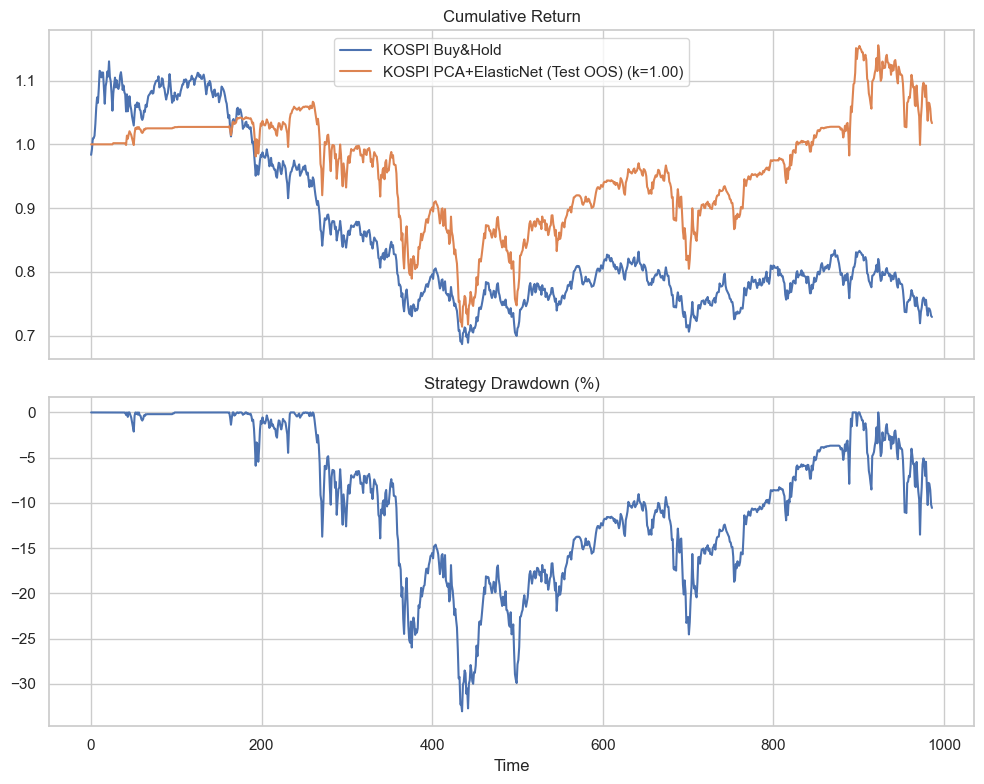

In [54]:
# 누적수익 / 드로우다운 그래프
def plot_equity_dd(returns, signal, k, max_vol_ratio=1.2,
                   name="KOSPI PCA+ElasticNet"):
    z = (signal - signal.mean()) / (signal.std() + 1e-12)
    raw_pos = (1.0 + k * z).clip(0.0, 2.0)

    strat_ret_raw = raw_pos * returns
    mkt_ret = returns

    ann = np.sqrt(252)
    strat_vol_raw = strat_ret_raw.std() * ann
    mkt_vol = mkt_ret.std() * ann
    vol_ratio_raw = strat_vol_raw / (mkt_vol + 1e-12)

    if vol_ratio_raw <= max_vol_ratio:
        scale = 1.0
    else:
        scale = max_vol_ratio / (vol_ratio_raw + 1e-12)

    pos = (raw_pos * scale).clip(0.0, 2.0)
    strat_ret = pos * returns

    strat_cum = (1 + strat_ret).cumprod()
    mkt_cum   = (1 + mkt_ret).cumprod()

    strat_cum_max = strat_cum.cummax()
    strat_dd = strat_cum / strat_cum_max - 1.0

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    axes[0].plot(mkt_cum.values, label="KOSPI Buy&Hold")
    axes[0].plot(strat_cum.values, label=f"{name} (k={k:.2f})")
    axes[0].set_title("Cumulative Return")
    axes[0].legend()

    axes[1].plot(strat_dd.values * 100)
    axes[1].set_title("Strategy Drawdown (%)")
    axes[1].set_xlabel("Time")

    plt.tight_layout()
    plt.show()

plot_equity_dd(test_returns, test_signal, best_k,
               max_vol_ratio=1.2,
               name="KOSPI PCA+ElasticNet (Test OOS)")

In [55]:
def plot_test_oos_summary(
    returns: pd.Series,
    signal: pd.Series,
    k: float,
    max_vol_ratio: float = 1.2,
    name: str = "KOSPI PCA+ElasticNet (Test OOS)",
    window_vol: int = 63,
    annualization: int = 252,
):
    """
    returns : Test 구간 실제 수익률 (pd.Series)  -> test_returns
    signal  : Test 구간 예측 신호 (pd.Series)   -> test_signal
    k       : train에서 찾은 best_k
    max_vol_ratio : 전략 변동성 / 벤치마크 변동성 상한 (ex. 1.2)
    """

    # 1) 포지션 생성 (z-score -> 1 + k*z -> [0,2] clip)
    z = (signal - signal.mean()) / (signal.std() + 1e-12)
    raw_pos = (1.0 + k * z).clip(0.0, 2.0)

    strat_ret_raw = raw_pos * returns
    mkt_ret = returns

    ann = np.sqrt(annualization)
    strat_vol_raw = strat_ret_raw.std() * ann
    mkt_vol = mkt_ret.std() * ann
    vol_ratio_raw = strat_vol_raw / (mkt_vol + 1e-12)

    # 2) 변동성 캡 적용 (<= max_vol_ratio)
    if vol_ratio_raw <= max_vol_ratio:
        scale = 1.0
    else:
        scale = max_vol_ratio / (vol_ratio_raw + 1e-12)

    pos = (raw_pos * scale).clip(0.0, 2.0)
    strat_ret = pos * returns

    # 3) 누적수익 / 드로우다운
    strat_cum = (1 + strat_ret).cumprod()
    mkt_cum   = (1 + mkt_ret).cumprod()

    strat_cum_max = strat_cum.cummax()
    strat_dd = strat_cum / strat_cum_max - 1.0

    mkt_cum_max = mkt_cum.cummax()
    mkt_dd = mkt_cum / mkt_cum_max - 1.0

    # 4) 롤링 변동성 (연율화)
    strat_vol_roll = strat_ret.rolling(window_vol).std() * ann
    mkt_vol_roll   = mkt_ret.rolling(window_vol).std() * ann

    # 5) 핵심 지표 계산
    mean_ret_mkt   = mkt_ret.mean() * annualization
    mean_ret_strat = strat_ret.mean() * annualization
    vol_mkt        = mkt_vol
    vol_strat      = strat_ret.std() * ann
    sharpe_mkt     = mean_ret_mkt / (vol_mkt + 1e-12)
    sharpe_strat   = mean_ret_strat / (vol_strat + 1e-12)

    max_dd_mkt   = mkt_dd.min() * 100
    max_dd_strat = strat_dd.min() * 100

    print("=== Test OOS Performance ===")
    print(f"Best k (from train) : {k:.3f}")
    print(f"Scale factor        : {scale:.3f}")
    print(f"Vol ratio (raw)     : {vol_ratio_raw:.3f}x")
    print()
    print("Benchmark (Buy&Hold)")
    print(f"  Ann. Return       : {mean_ret_mkt*100:.3f}%")
    print(f"  Ann. Vol          : {vol_mkt*100:.3f}%")
    print(f"  Sharpe            : {sharpe_mkt:.3f}")
    print(f"  Max Drawdown      : {max_dd_mkt:.2f}%")
    print()
    print(name)
    print(f"  Ann. Return       : {mean_ret_strat*100:.3f}%")
    print(f"  Ann. Vol          : {vol_strat*100:.3f}%")
    print(f"  Vol Ratio         : {vol_strat/(vol_mkt+1e-12):.3f}x")
    print(f"  Sharpe            : {sharpe_strat:.3f}")
    print(f"  Max Drawdown      : {max_dd_strat:.2f}%")

    # 6) 플롯: 누적수익 / 드로우다운 / 롤링 변동성
    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    # (1) 누적수익
    axes[0].plot(mkt_cum.values, label="Benchmark (w=1)")
    axes[0].plot(strat_cum.values, label=f"{name}")
    axes[0].set_title("Cumulative Return (Test OOS)")
    axes[0].legend()

    # (2) 드로우다운
    axes[1].plot(mkt_dd.values * 100, label="Benchmark DD")
    axes[1].plot(strat_dd.values * 100, label="Strategy DD")
    axes[1].set_title("Drawdown (%) – Benchmark vs Strategy")
    axes[1].legend()

    # (3) 롤링 변동성
    axes[2].plot(mkt_vol_roll.values, label="Benchmark Rolling Vol")
    axes[2].plot(strat_vol_roll.values, label="Strategy Rolling Vol")
    axes[2].axhline(mkt_vol * max_vol_ratio, color="red", linestyle="--", alpha=0.7,
                    label=f"Vol Cap ({max_vol_ratio:.1f}×)")
    axes[2].set_title(f"Rolling {window_vol}-Day Annualized Volatility")
    axes[2].set_xlabel("Time")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    # 7) 보고서용 숫자 뽑아쓰라고 metrics 리턴
    metrics = {
        "scale": float(scale),
        "vol_ratio_raw": float(vol_ratio_raw),
        "ann_ret_bench": float(mean_ret_mkt),
        "ann_vol_bench": float(vol_mkt),
        "sharpe_bench": float(sharpe_mkt),
        "max_dd_bench_pct": float(max_dd_mkt),
        "ann_ret_strat": float(mean_ret_strat),
        "ann_vol_strat": float(vol_strat),
        "sharpe_strat": float(sharpe_strat),
        "max_dd_strat_pct": float(max_dd_strat),
    }
    return metrics

=== Test OOS Performance ===
Best k (from train) : 1.000
Scale factor        : 0.878
Vol ratio (raw)     : 1.367x

Benchmark (Buy&Hold)
  Ann. Return       : -6.706%
  Ann. Vol          : 16.390%
  Sharpe            : -0.409
  Max Drawdown      : -39.21%

KOSPI PCA+ElasticNet (Test OOS)
  Ann. Return       : 2.768%
  Ann. Vol          : 19.668%
  Vol Ratio         : 1.200x
  Sharpe            : 0.141
  Max Drawdown      : -33.03%


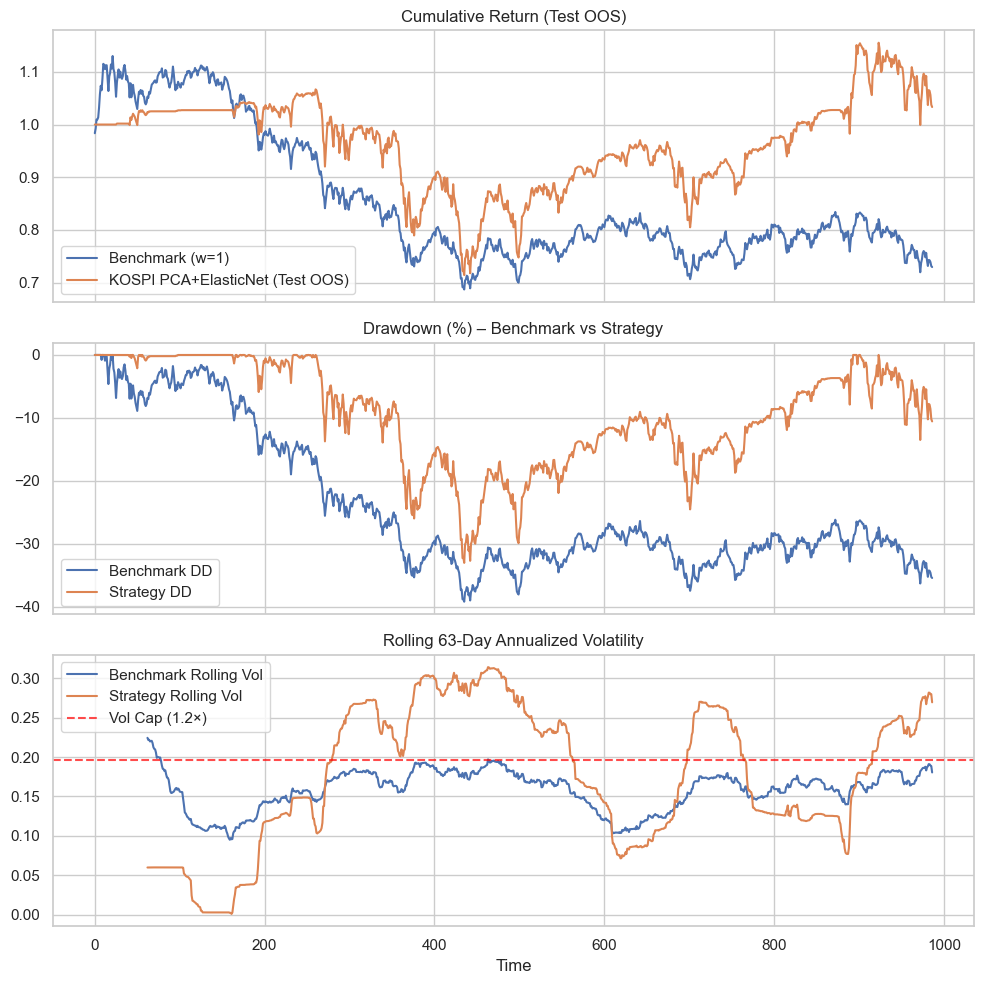

{'scale': 0.8775224274477413,
 'vol_ratio_raw': 1.3674864168307372,
 'ann_ret_bench': -0.06705727520243411,
 'ann_vol_bench': 0.1639016064657053,
 'sharpe_bench': -0.40913128704480395,
 'max_dd_bench_pct': -39.20746047969197,
 'ann_ret_strat': 0.027681614875929267,
 'ann_vol_strat': 0.1966819277599025,
 'sharpe_strat': 0.14074305245564084,
 'max_dd_strat_pct': -33.03491659047728}

In [56]:
test_metrics = plot_test_oos_summary(
    returns=test_returns,
    signal=test_signal,
    k=best_k,
    max_vol_ratio=1.2,
    name="KOSPI PCA+ElasticNet (Test OOS)"
)

test_metrics